<a href="https://colab.research.google.com/github/umangSharmacs/Charles_research_codes/blob/main/ICSI_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import csv
from nltk.tag import pos_tag # for proper noun
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import math
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tag import DefaultTagger
import os
import numpy as np
import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

import gensim
from gensim.parsing.preprocessing import remove_stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Transcripts should be in the transcripts folder of your drive folder, and drive should be mounted

filelist=os.listdir('/content/drive/MyDrive/transcripts/')
root_list=[]
meeting_name_list=[]
participants_list=[]
text_list=[]
time_list=[]
for file in filelist:
  if file[-3:]=='mrt':
    tree = ET.parse(f'/content/drive/MyDrive/transcripts/{file}')
    root = tree.getroot()
    root_list.append(root)
  # meeting_name=root.attrib['Session']
  # meeting_name_list.append(meeting_name)
  # participants=[]
  # for child in root[0][2]:
  #     participants.append(child.attrib['Name'])
  #     participants_list.append(participants)
  # time = float(root[1].attrib['EndTime'])-float(root[1].attrib['StartTime'])
  # time_list.append(time)
  # txt=[]
  # for child in root[1]:
  #   txt.append(child.text)
  # text_list.append(txt)

In [ ]:
def preprocess(text):
    
    sent_tokens = nltk.sent_tokenize(text)
   
    word_tokens = nltk.word_tokenize(text)
    word_tokens_lower=[word.lower() for word in word_tokens]
    
    stopWords = list(set(stopwords.words("english")))
    word_tokens_refined=[x for x in word_tokens_lower if x not in stopWords]
    #print(len(word_tokens_refined))
    
    stem = []
    ps = PorterStemmer()
    for w in word_tokens_refined:
        stem.append(ps.stem(w))
    word_tokens_refined=stem
    
    return text,sent_tokens,word_tokens,word_tokens_lower,word_tokens_refined

In [ ]:
dataframes_list=[]
# filelist=os.listdir('/content/drive/MyDrive/transcripts/')
# for file in filelist:
#   tree = ET.parse('/content/drive/MyDrive/transcripts/Bdb001.mrt')
#   root = tree.getroot()
for root in root_list:
  text=[]
  sent_tokens=[]
  word_tokens=[]
  word_tokens_lower=[]
  word_tokens_refined=[]
  time=[]
  bag={}
  for child in root[1]:
      time.append(float(child.attrib['StartTime'])+(float(child.attrib['EndTime'])-float(child.attrib['StartTime']))/2)
      t=preprocess(child.text)
      text.append(t[0])
      sent_tokens.append(t[1])
      word_tokens.append(t[2])
      word_tokens_lower.append(t[3])
      word_tokens_refined.append(t[4])

  for words in word_tokens_refined:
    for word in words:
      if word in bag:
        bag[word]+=1
      else:
        bag[word]=1
  for k in bag.keys():
          bag[k]= math.log10(1+bag[k])
  sent_scores=[]
  for words in word_tokens_refined:
    score=0
    for word in words:
      if word in bag:
        score+=bag[word]
    sent_scores.append(score)
  df=pd.DataFrame()
  df['sentences']=text
  df['refined_word_tokens']=word_tokens_refined
  df['time']=time
  df['score']=sent_scores
  df=df.sort_values('score', ascending=False)
  df=df.sort_index()
  dataframes_list.append(df)
  del df
  # plt.plot(df['score'])
  # plt.scatter(x=df.sort_values('score', ascending=False).index[:5],y=df.sort_values('score', ascending=False)['score'][:5], color='r')

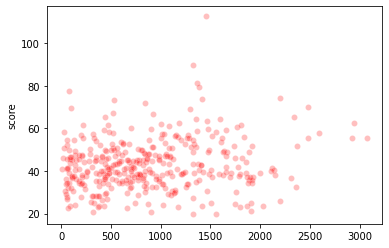

In [ ]:
df=dataframes_list[2]
for df in dataframes_list:
  sns.scatterplot(x=df.sort_values('score', ascending=False).index[:5],y=df.sort_values('score', ascending=False)['score'][:5], color='r', alpha=0.25)

In [ ]:
# parameter based on lenght of doc, length of highest scoring sentence, highest score, distribution of score.

22

In [ ]:
# Apply TFIDF using time difference as variation.

In [ ]:
time = float(root[1].attrib['EndTime'])-float(root[1].attrib['StartTime'])
df=df.sort_index()
docs=[]
doc_lengths=range(len(df)//5,len(df),len(df)//5)
for index,i in enumerate(doc_lengths[:-1]):
  docs.append(df.iloc[doc_lengths[index]:doc_lengths[index+1]])





In [ ]:
df_dict={}
n=len(docs)
for index,df in enumerate(docs):
  for words in df['refined_word_tokens']:
    for word in words:
      df_dict[word]=[0]*n


for index,df in enumerate(docs):
  for words in df['refined_word_tokens']:
    for word in words:
      df_dict[word][index]=1

for word in df_dict.keys():
  df_dict[word]=(math.log(n/sum(df_dict[word]))+1)

In [ ]:
tfidf_scores=[]
for word_list in df['refined_word_tokens']:
  score=0
  for word in word_list:
    if word in bag:
      score+=(bag[word]*df_dict[word])
  tfidf_scores.append(score)
df['tfidf']=tfidf_scores

In [ ]:
df.sort_values('tfidf', ascending=False)[:5]

,sentences,refined_word_tokens,time,score,tfidf
1331,\n Transcript number three three three on...,"[transcript, number, three, three, three, one,...",3021.968,21.000903,32.216060
1196,\n So - so imagine - I think his - his ex...,"[-, imagin, -, think, -, exampl, good, one, .,...",3021.968,26.961420,31.102187
1257,"\n transcript two seven three one, two se...","[transcript, two, seven, three, one, ,, two, s...",3021.968,20.237877,30.879743
1307,"\n Transcript one four five one, one four...","[transcript, one, four, five, one, ,, one, fou...",3021.968,20.560694,29.996249
1145,"\n But, you know, it had lots of errors a...","[,, know, ,, lot, error, thing, would, end, wr...",3021.968,27.262056,29.867270


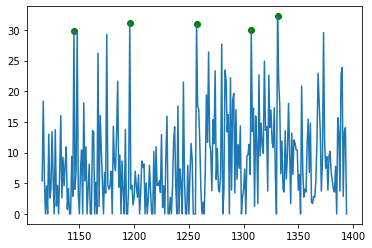

In [ ]:
df=df.sort_index()

plt.plot(df['tfidf'])
plt.scatter(x=df.sort_values('tfidf', ascending=False).index[:5],y=df.sort_values('tfidf', ascending=False)['tfidf'][:5], color='g')

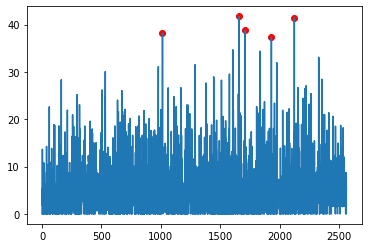

In [ ]:
  df=dataframes_list[0]
  plt.plot(df['score'])
  plt.scatter(x=df.sort_values('score', ascending=False).index[:5],y=df.sort_values('score', ascending=False)['score'][:5], color='r')